In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

In [3]:
crop_data = pd.read_csv("data/Crop_Location_Data.csv")
crop_data.head()

Latitude and Longitude Class of Land
0   (10.323727047081501, 105.2516346045924)          Rice
1  (10.322364360592521, 105.27843410554115)          Rice
2  (10.321455902933202, 105.25254306225168)          Rice
3  (10.324181275911162, 105.25118037576274)          Rice
4  (10.324635504740822, 105.27389181724476)          Rice

In [4]:
crop_data.tail()

Latitude and Longitude Class of Land
595  (10.013942985253381, 105.67361318732796)      Non Rice
596   (10.01348875642372, 105.67361318732796)      Non Rice
597  (10.013034527594062, 105.67361318732796)      Non Rice
598  (10.012580298764401, 105.67361318732796)      Non Rice
599  (10.012126069934741, 105.67361318732796)      Non Rice

In [5]:
crop_data = pd.read_csv('data/Crop_Data_vv_vh.csv')
crop_data.head()

vh        vv Class of Land
0  0.041293  0.114049          Rice
1  0.026896  0.147442          Rice
2  0.021583  0.277267          Rice
3  0.035070  0.154607          Rice
4  0.041903  0.191198          Rice

In [6]:
crop_data.tail()

vh        vv Class of Land
595  0.042756  0.168274      Non Rice
596  0.050055  0.274366      Non Rice
597  0.076976  0.460802      Non Rice
598  0.124859  0.320639      Non Rice
599  0.054056  0.175985      Non Rice

In [5]:
# Calculating the RVI
crop_data['RVI'] = (1 + np.sqrt(crop_data['vv'] / crop_data['vh'])) / (1 - np.sqrt(crop_data['vv'] / crop_data['vh']))

In [6]:
crop_data.head()

vh        vv Class of Land       RVI
0  0.041293  0.114049          Rice -4.021544
1  0.026896  0.147442          Rice -2.491036
2  0.021583  0.277267          Rice -1.773941
3  0.035070  0.154607          Rice -2.818743
4  0.041903  0.191198          Rice -2.760424

In [7]:
category = {'Rice': 1, 'Non Rice':0}

crop_data['Class of Land'] = crop_data['Class of Land'].map(category)

In [8]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data['Class of Land'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y,random_state=40)

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Logistic Regression

In [10]:
model = LogisticRegression(solver='lbfgs')
model.fit(X_train,y_train)

LogisticRegression()

In [11]:
predictions = model.predict(X_test)

print("Logistic Regression Model Accuracy {0:.2f}%".format(100*accuracy_score(predictions,y_test)))
print(classification_report(predictions,y_test))

Logistic Regression Model Accuracy 57.22%
              precision    recall  f1-score   support

           0       0.49      0.59      0.53        75
           1       0.66      0.56      0.61       105

    accuracy                           0.57       180
   macro avg       0.57      0.57      0.57       180
weighted avg       0.59      0.57      0.58       180



In [12]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):

    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

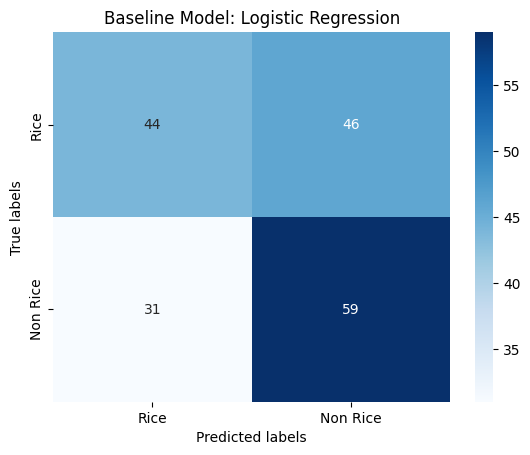

In [13]:
plot_confusion_matrix(y_test, predictions,"Baseline Model: Logistic Regression",['Rice', 'Non Rice'])

#### RandomForest Classifier

In [14]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=40)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

Random Forest Classifier Accuracy: 69.44%
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71        90
           1       0.72      0.64      0.68        90

    accuracy                           0.69       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.70      0.69      0.69       180



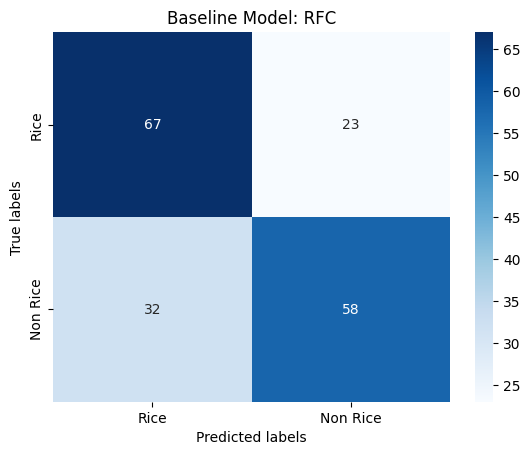

In [15]:
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {100*accuracy:.2f}%")

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
plot_confusion_matrix(y_test, y_pred,"Baseline Model: RFC",['Rice', 'Non Rice'])

#### Hyperparameter Optimiation  - Hyperopt

In [16]:
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 200)),
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']),
}


def objective(params):
    clf = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
        random_state=40,
        n_jobs=-1,
    )
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1).mean()
    return -score


best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    verbose=2,
)

print("Best hyperparameters:", best)

100%|██████████| 100/100 [00:31<00:00,  3.22trial/s, best loss: -0.7285714285714286]
Best hyperparameters: {'max_depth': 7, 'max_features': 0, 'min_samples_leaf': 0.10187941537771256, 'min_samples_split': 0.4055100006007677, 'n_estimators': 56}


Random Forest Classifier Accuracy: 69.44%
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.74      0.71        90
           1       0.72      0.64      0.68        90

    accuracy                           0.69       180
   macro avg       0.70      0.69      0.69       180
weighted avg       0.70      0.69      0.69       180



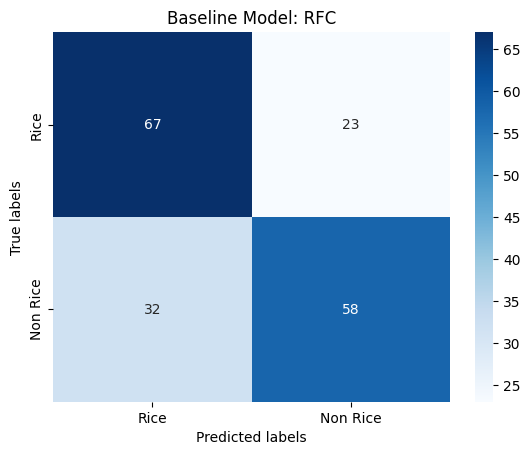

In [17]:
rf_clf_opt = RandomForestClassifier(
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_split=best['min_samples_split'],
    min_samples_leaf=best['min_samples_leaf'],
    max_features=['auto', 'sqrt', 'log2'][best['max_features']],
    random_state=40,
    n_jobs=-1,
)
rf_clf_opt.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {100*accuracy:.2f}%")

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
plot_confusion_matrix(y_test, y_pred,"Baseline Model: RFC",['Rice', 'Non Rice'])


### XGBoost Classifier

In [21]:
def objective(params):
    clf = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='error', n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = -np.mean(cross_val_score(clf, X, y, cv=cv, scoring='accuracy', n_jobs=-1))
    return {'loss': score, 'status': STATUS_OK}


space = {
    'n_estimators': hp.choice('n_estimators', np.arange(50, 1000, 25, dtype=int)),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(1, 10)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
}


trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials, verbose=2)

100%|██████████| 100/100 [00:22<00:00,  4.47trial/s, best loss: -0.7433333333333334]


In [22]:
best

{'colsample_bytree': 0.976536593313706,
 'gamma': 0.526241209139956,
 'learning_rate': 0.03768961749730772,
 'max_depth': 8,
 'min_child_weight': 9.0,
 'n_estimators': 24,
 'subsample': 0.691371123072425}

Random Forest Classifier Accuracy: 71.67%
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.80      0.74        90
           1       0.76      0.63      0.69        90

    accuracy                           0.72       180
   macro avg       0.72      0.72      0.71       180
weighted avg       0.72      0.72      0.71       180



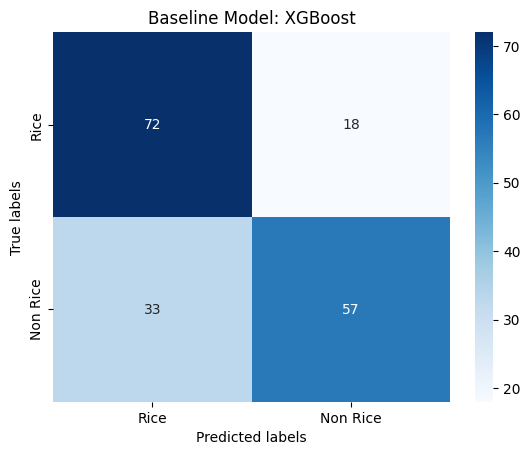

In [23]:
best_params = {key: int(value) if "n_" in key or "depth" in key else value for key, value in best.items()}
xgboost_clf = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric='error', n_jobs=-1)
xgboost_clf.fit(X_train, y_train)

y_pred = xgboost_clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Classifier Accuracy: {100*accuracy:.2f}%")

# Generate a classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
plot_confusion_matrix(y_test, y_pred,"Baseline Model: XGBoost",['Rice', 'Non Rice'])